# Retinal Warping

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from scipy import optimize
npa = np.array

import sys
sys.path.insert(0, '..')

import math

In [2]:
import os
print(os.getcwd())
#os.chdir()

/Users/laurentperrinet/quantic/science/ActiveVision/POLO/notebooks


The delta_lookup function simulates cone density as a function of eccentricity.

>    delta_lookup: $r \rightarrow r'$

>    $d[i] =  1 / \sqrt{\pi \cdot \rho_{fovea}} \cdot exp(a/2 * r[i]) $

>    $r'[i] = r[i-1] + d[i-1]$

where 

$r$: cone position along radial axis in input space (same as eccentricity)

$r^\prime$: cone position along radial axis in output space (can be considered as the index of cones)

$d$: distance between cones

$\rho_{fovea}$: cones density at fovea

$a: \frac{log(\text{max ratio})}{r_{max}}$

max_ratio: (cone density @ fovea) / (cone density @ periphery). This ratio equal 10 for 4 degrees of visual field in primates. 

c.f. Watson, A. B. (2016). A formula for human retinal ganglion cell receptive field density as a function of visual field location. Journal of Vision, 14(2014), 1–17. https://doi.org/10.1167/14.7.15.doi


distance = 1/ density

density at r = $\sqrt{\pi  \rho_\text{fovea}}  \exp(- \frac{r}{r_\text{max}}\frac{\log \text{max_ratio}}{2})$ 

Text(0.5, 1.0, 'cell density')

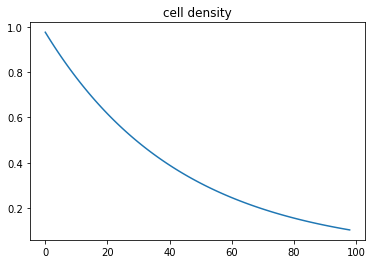

In [3]:
r_max = 100
max_ratio = 100
plt.plot(np.exp(- np.arange(1, r_max)/(2 * r_max) * np.log(max_ratio)))
plt.title('cell density')

Text(0.5, 0, 'cell index (eccentricity)')

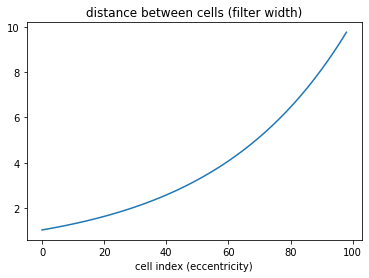

In [4]:
plt.plot(1/(np.exp(- np.arange(1, r_max)/(2 * r_max) * np.log(max_ratio))))
plt.title('distance between cells (filter width)')
plt.xlabel('cell index (eccentricity)')

Text(0.5, 0, 'cell index (eccentricity)')

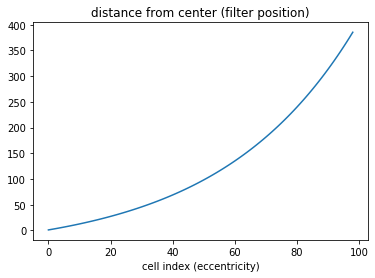

In [5]:
plt.plot(np.cumsum(1/(np.exp(- np.arange(1, r_max)/(2 * r_max) * np.log(max_ratio)))))
plt.title('distance from center (filter position)')
plt.xlabel('cell index (eccentricity)')

## Determine the cone density at fovea

The value of rho_fovea needs to be tuned such that the computed r covers the entire input space.
This number depends on both input and output sizes. The retinawarp function warps the image data within the image of size "input_size" into an image of size "output_size".

`get_rf_value` function could be called to find the optimal $\rho_{fovea}$ value.

In [9]:
%cd ..

/Users/laurentperrinet/quantic/science/ActiveVision/POLO


In [10]:
from dev.retina.common import get_rf_value
# Use newton's law to find the solution instead of manual approach above.
# Last r should be equal half the in_size

in_size=800 #440
out_size=100 #220

optimal_rf = get_rf_value(in_size, out_size)
print('Optimal RF for input size [{0}x{0}] and output size [{1}x{1}]: {2:.2f}'.format(in_size, out_size, optimal_rf))


ModuleNotFoundError: No module named 'dev.retina.common'; 'dev.retina' is not a package

In [ ]:
r_max = 100
max_ratio = 100
periphery_rf = optimal_rf / max_ratio
periphery_rf


In [ ]:
a = np.log(max_ratio) / r_max
a

In [ ]:
r_prim = np.zeros(r_max)
for r in range(1, r_max):
    r_prim[r] = r_prim[r-1] + 1 / np.sqrt(np.pi * optimal_rf) * np.exp(a/2 * r)

In [ ]:
plt.plot(np.arange(r_max), r_prim)

In [ ]:
import numpy as np
from retina.common import delta_lookup, fit_func
from skimage.util import crop, pad
from skimage.transform import resize, warp

npa = np.array


def get_fit_func(fit_mode='quad'):
  """
  Gets the fitting function matching the fit_mode ['quad', 'linear', 'exp']
  :param fit_mode: choice of the fitting function ['quad', 'linear', 'exp']
  :return: fitting function
  """
  if fit_mode == 'quad':
    func = lambda x, a, b: a * x ** 2 + b * x
  elif fit_mode == 'linear':
    func = lambda x, a, b: a * x + b
  elif fit_mode == 'exp':
    func = lambda x, a, b: np.exp(a * x) + b
  else:
    raise ValueError('Fit mode not defined. Choices are ''linear'', ''exp''.')
  return func


def warp_func(xy, func, a, b):
  """
  Warps the xy points given the function func and parameter a and b.
  :param xy: Input points [2 x num_points]
  :param func: Warping function
  :param a: func parameter 1
  :param b: func parameter 2
  :return: Transformed points on the original image
  """
  center = np.mean(xy, axis=0)
  xc, yc = (xy - center).T

  # Polar coordinates
  r = np.sqrt(xc ** 2 + yc ** 2)
  theta = np.arctan2(yc, xc)

  r = func(r, a, b)
  out = np.column_stack((
    r * np.cos(theta), r * np.sin(theta)
  ))
  out = out + center
  return out


def warp_image(image, output_size=None, input_size=None, fill_value=0., fit_mode = 'quad'):
  """
  transforms the input image using a fisheye transformation
  :param image: (ndarray) input image
  :param output_size: (int) size of the output image
  :param fill_value: (float) value to fill in the missing values with
  :return: (ndarray) transformed image
  """
  original_shape = npa(image.shape[:2])

  if input_size is None:
    input_size = np.min([original_shape[0], original_shape[1]])

  if output_size is None:
    output_size = np.min(image.shape[0:2])


  if any(original_shape < output_size):
    scale_ratio = np.max(float(output_size) / original_shape)
    warped_img = resize(image, npa(scale_ratio*original_shape, dtype=int))
    input_size = npa(input_size * scale_ratio, dtype=int)
  else:
    warped_img = image

  shape_diff = output_size - npa(warped_img.shape[:2])


  r, r_raw = delta_lookup(in_size=input_size, out_size=output_size)
  func = get_fit_func(fit_mode=fit_mode)
  popt, pcov = fit_func(func, r, r_raw)
  warped_img = warp(warped_img, warp_func, map_args={'func': func, 'a': popt[0], 'b': popt[1]}, cval=fill_value)

  if any(shape_diff < 0):
    crop_width = -shape_diff * (npa(shape_diff) < 0).astype(int)
    warped_img = crop(warped_img, crop_width=((crop_width[0]//2,)*2, (crop_width[1]//2,)*2, (0, 0)))

  # if any(shape_diff > 0):
  #   pad_width = shape_diff * (npa(shape_diff) > 0).astype(int)
  #   warped_img = pad(warped_img, pad_width=((pad_width[0]//2,)*2, (pad_width[1]//2,)*2, (0, 0)), mode='constant')

  return warped_img


In [ ]:
#from retina.common import delta_lookup, fit_func

rprime, r= delta_lookup(in_size, out_size, max_ratio=10.)

# find_retina_mapping(fit_mode='quad')
func = lambda x, a, b: a * x ** 2 + b * x
retina_func = func
popt, pcov = fit_func(func, rprime, r)
retina_pars = popt

# simulated version
r_s = np.arange(out_size/2+1, step=16)
r_simulated = np.tile(r_s, (20,1)).T.flatten()
theta = np.tile(np.linspace(-np.pi, np.pi, 20), (1, len(r_s)))
r_simulated = retina_func(r_simulated, *retina_pars)
x_simulated = in_size/2. + r_simulated*np.cos(theta)
y_simulated = in_size/2. + r_simulated*np.sin(theta)

# real sampling version
#xy = warp_func(xy_out, in_size, retina_func, retina_pars, shift=None)
xy_out = np.indices((out_size, out_size))[:,::16,::16][:,1:,1:].reshape(2,-1)
xy_out = xy_out - out_size/2. 
r_out = np.linalg.norm(xy_out, axis=0)
theta = np.arctan2(xy_out[1], xy_out[0])


r = retina_func(r_out, *retina_pars)
x = in_size/2. + r*np.cos(theta)
y = in_size/2. + r*np.sin(theta)


# Plot
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].add_patch(matplotlib.patches.Rectangle((0,0), in_size, in_size, fill=False))
ax[0].scatter(x_simulated, y_simulated, color='r')
ax[0].axvline(in_size/2., ls='--', c='b')
ax[0].axhline(in_size/2., ls='--', c='b')
ax[0].axis('equal')
ax[0].set_title('simulated cones \n(for visualization)')

ax[1].add_patch(matplotlib.patches.Rectangle((0,0), in_size, in_size, fill=False))
ax[1].scatter(x, y, color='r')
ax[1].axvline(in_size/2., ls='--', c='b')
ax[1].axhline(in_size/2., ls='--', c='b')
ax[1].axis('equal')
ax[1].set_title('simulated sampling')

plt.show()

In [ ]:
popt

In [ ]:
pcov

# Retina Transform With Numpy

In [ ]:
#from retina.retina import warp_image
import imageio
from skimage.transform import resize
import matplotlib.pyplot  as plt
%matplotlib inline

RESIZE_SCALE = 1

input_size = 800 / 2
output_size = 100

img_orig = imageio.imread('800px-Fox_Hunt_1893_Winslow_Homer.jpg')
img = resize(img_orig, np.array(RESIZE_SCALE*npa(img_orig.shape[:2]), dtype=int))
ret_img = warp_image(img, output_size=output_size, input_size=input_size, fit_mode='exp')
fig, axes = plt.subplots(ncols=2, figsize=(10,10))
axes[0].imshow(img_orig)
axes[1].imshow(ret_img)
plt.show()

# Retina Transform with Tensorflow

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from retina.retina_tf import warp_image
import imageio
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

RESIZE_SCALE = .75

import tensorflow as tf

with tf.Session() as sess:
    img_orig = imageio.imread('homer.jpg')
    img = resize(img_orig, RESIZE_SCALE*npa(img_orig.shape[:2]))
    retina_img = warp_image(img, output_size=700, input_size=350)
    retina_img = retina_img.eval()
fig, axes = plt.subplots(ncols=2, figsize=(10,10))
axes[0].imshow(img_orig)
axes[1].imshow(retina_img)
plt.show()